Categorical columns: Index(['State', 'Sex', 'GeneralHealth', 'LastCheckupTime',
       'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
       'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
       'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')
Epoch 1/10
12302/12302 [==============================] - 9s 679us/step - loss: 0.1539 - accuracy: 0.9457 - val_loss: 0.1461 - val_accuracy: 0.9479
Epoch 2/10
12302/12302 [==============================] - 8s 674us/step - loss: 0.1472 - accuracy: 0.9480 - val_loss: 0.1505 - val_accuracy: 0.9487
Ep

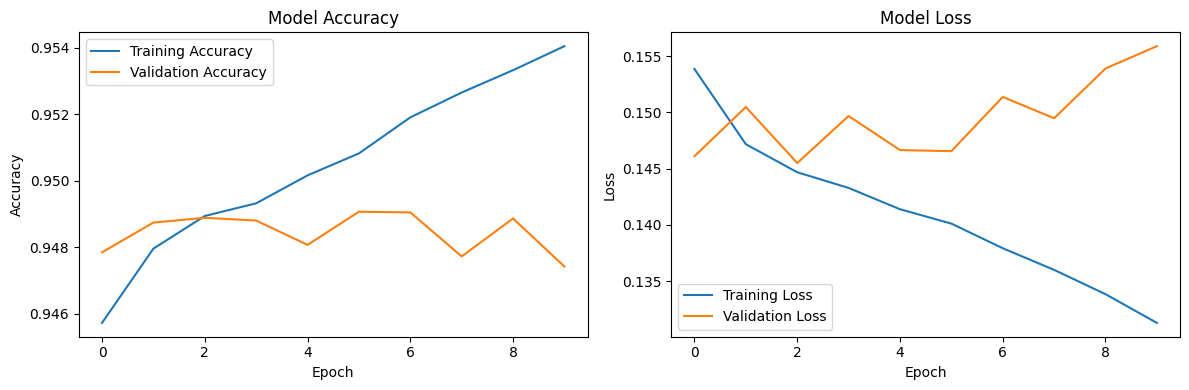

In [6]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('/Users/moiz/Downloads/heart_2022_no_nans.csv')

# Separate features and target
X = df.drop('HadHeartAttack', axis=1)
y = pd.get_dummies(df['HadHeartAttack'], drop_first=True).iloc[:, 0]

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, 
                    validation_data=(X_test_scaled, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1538/1538 [==============================] - 0s 264us/step


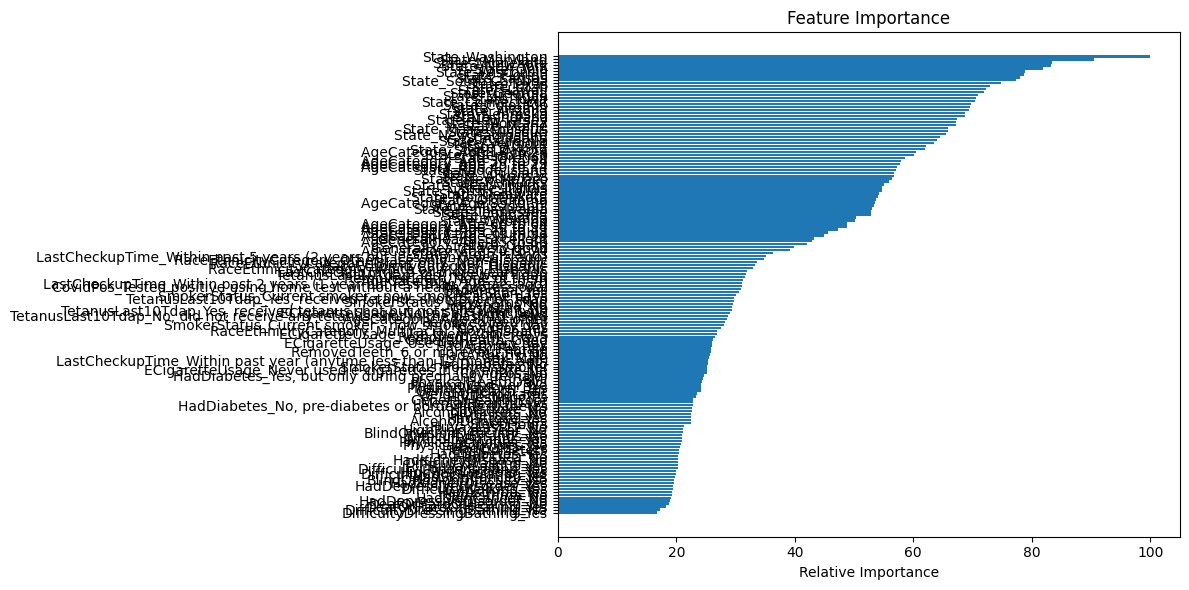

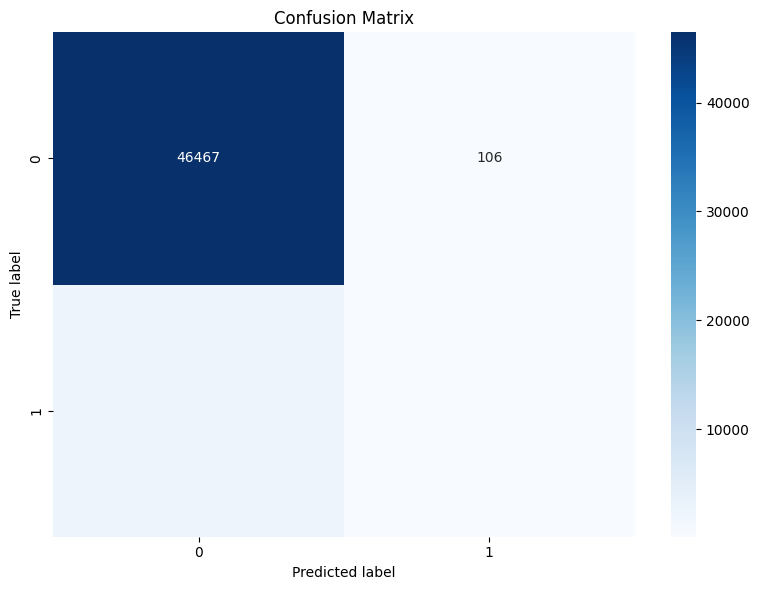

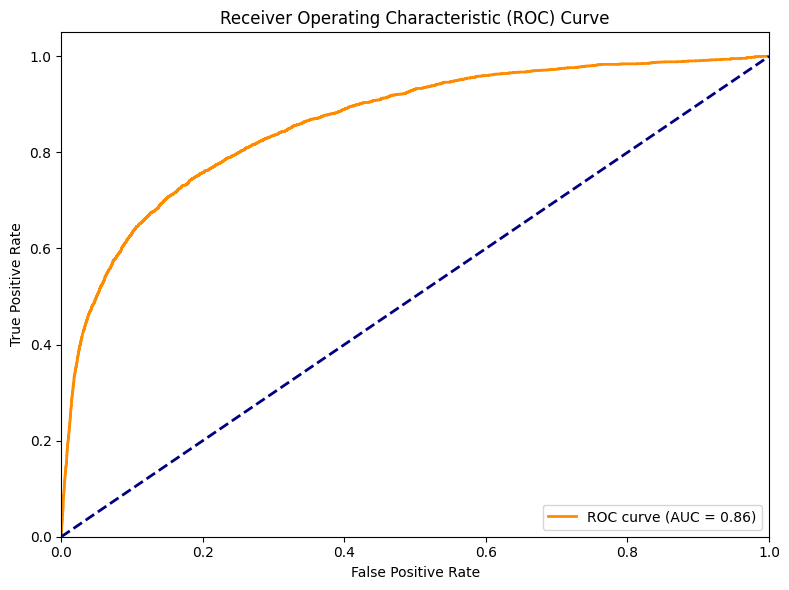

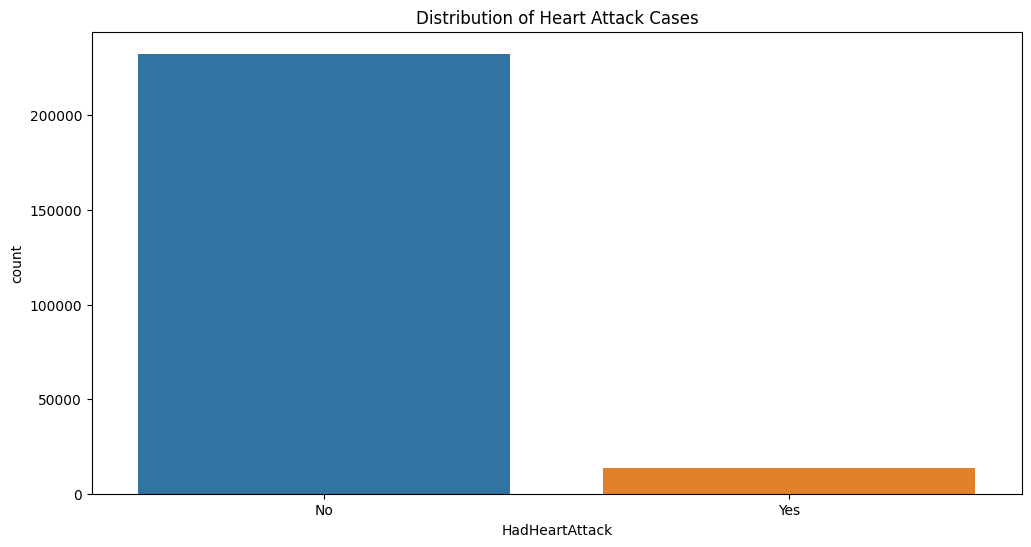

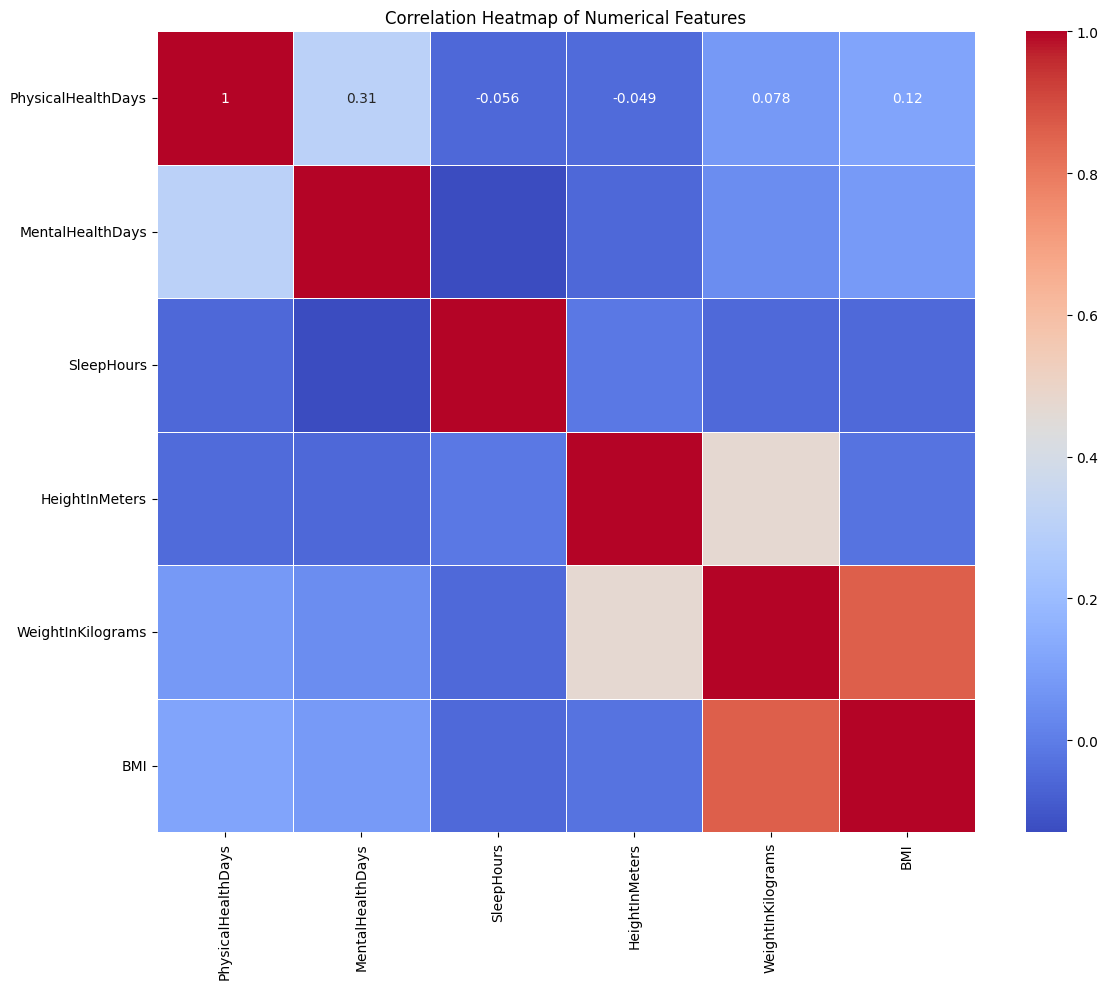

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

# Generate predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Plot feature importance
def plot_feature_importance(model, X):
    feature_importance = abs(model.layers[0].get_weights()[0]).mean(axis=1)
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, X_encoded)

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred_classes)

# Plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

plot_roc_curve(y_test, y_pred)

# Distribution of Heart Attack Cases
plt.figure(figsize=(12, 6))
sns.countplot(x='HadHeartAttack', data=df)
plt.title('Distribution of Heart Attack Cases')
plt.show()

# Correlation heatmap of numerical features
numerical_features = X.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

Health factors we're looking at: ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']


/var/folders/fd/n_lksln53nj3d_0j7209_rrw0000gn/T/ipykernel_2325/38511675.py:55: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', False):
/Users/moiz/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/moiz/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/moiz/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-

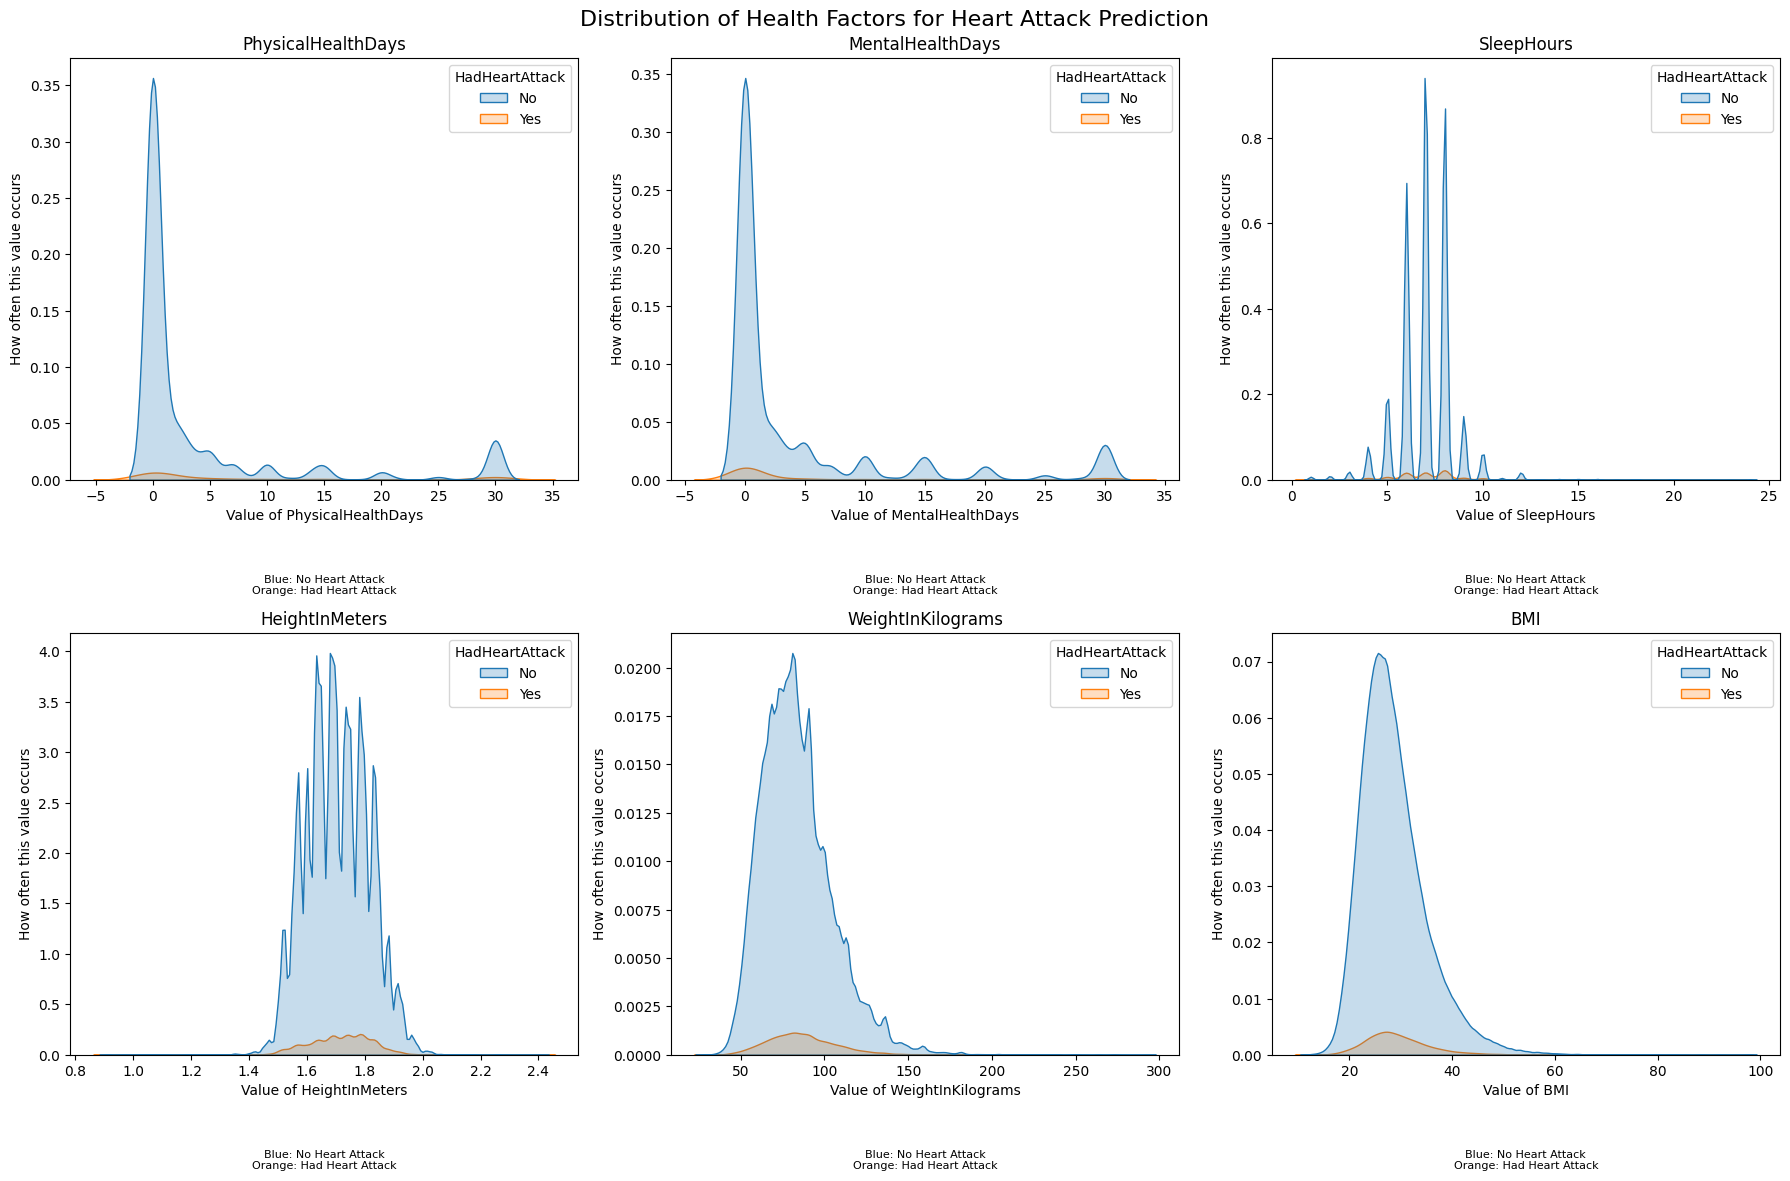


What do these graphs mean?
- Each graph shows how often different values of a health factor occur.
- The blue area is for people who didn't have a heart attack.
- The orange area is for people who had a heart attack.
- Where the colors overlap, both groups had similar values.
- If the colors are very different, that health factor might be important for predicting heart attacks.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_gaussian_distributions(df, target_column, features, n_cols=3):
    n_rows = (len(features) - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
    fig.suptitle('Distribution of Health Factors for Heart Attack Prediction', fontsize=16)
    
    for i, feature in enumerate(features):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        sns.kdeplot(data=df, x=feature, hue=target_column, fill=True, ax=ax)
        ax.set_title(feature, fontsize=12)
        ax.set_xlabel(f'Value of {feature}', fontsize=10)
        ax.set_ylabel('How often this value occurs', fontsize=10)
        
        # Add a simple explanation
        ax.text(0.5, -0.25, 
                "Blue: No Heart Attack\nOrange: Had Heart Attack", 
                ha='center', va='center', transform=ax.transAxes, fontsize=8)
        
    # Remove any unused subplots
    for i in range(len(features), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1:
            if col < axes.shape[1]:
                fig.delaxes(axes[row, col])
        else:
            if col < len(axes):
                fig.delaxes(axes[col])
    
    plt.tight_layout()
    plt.show()

# Select numerical features for plotting
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Safely remove 'HadHeartAttack' if it's in the list
if 'HadHeartAttack' in numerical_features:
    numerical_features.remove('HadHeartAttack')

# Print the features we're going to plot
print("Health factors we're looking at:", numerical_features)

# Handle inf values
df_plot = df.copy()
df_plot = df_plot.replace([np.inf, -np.inf], np.nan)

# Plot Gaussian distributions
with pd.option_context('mode.use_inf_as_na', False):
    plot_gaussian_distributions(df_plot, 'HadHeartAttack', numerical_features)

# Add an overall explanation
print("\nWhat do these graphs mean?")
print("- Each graph shows how often different values of a health factor occur.")
print("- The blue area is for people who didn't have a heart attack.")
print("- The orange area is for people who had a heart attack.")
print("- Where the colors overlap, both groups had similar values.")
print("- If the colors are very different, that health factor might be important for predicting heart attacks.")

Categorical columns: Index(['State', 'Sex', 'GeneralHealth', 'LastCheckupTime',
       'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
       'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
       'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')
Epoch 1/10
12302/12302 [==============================] - 8s 668us/step - loss: 0.1533 - accuracy: 0.9465 - val_loss: 0.1454 - val_accuracy: 0.9481
Epoch 2/10
12302/12302 [==============================] - 8s 671us/step - loss: 0.1471 - accuracy: 0.9479 - val_loss: 0.1477 - val_accuracy: 0.9492
Ep

/Users/moiz/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:49:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


1538/1538 [==============================] - 0s 278us/step

Neural Network Results:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     46573
           1       0.60      0.12      0.21      2632

    accuracy                           0.95     49205
   macro avg       0.78      0.56      0.59     49205
weighted avg       0.93      0.95      0.93     49205


XGBoost Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     46573
           1       0.55      0.24      0.33      2632

    accuracy                           0.95     49205
   macro avg       0.75      0.61      0.65     49205
weighted avg       0.94      0.95      0.94     49205



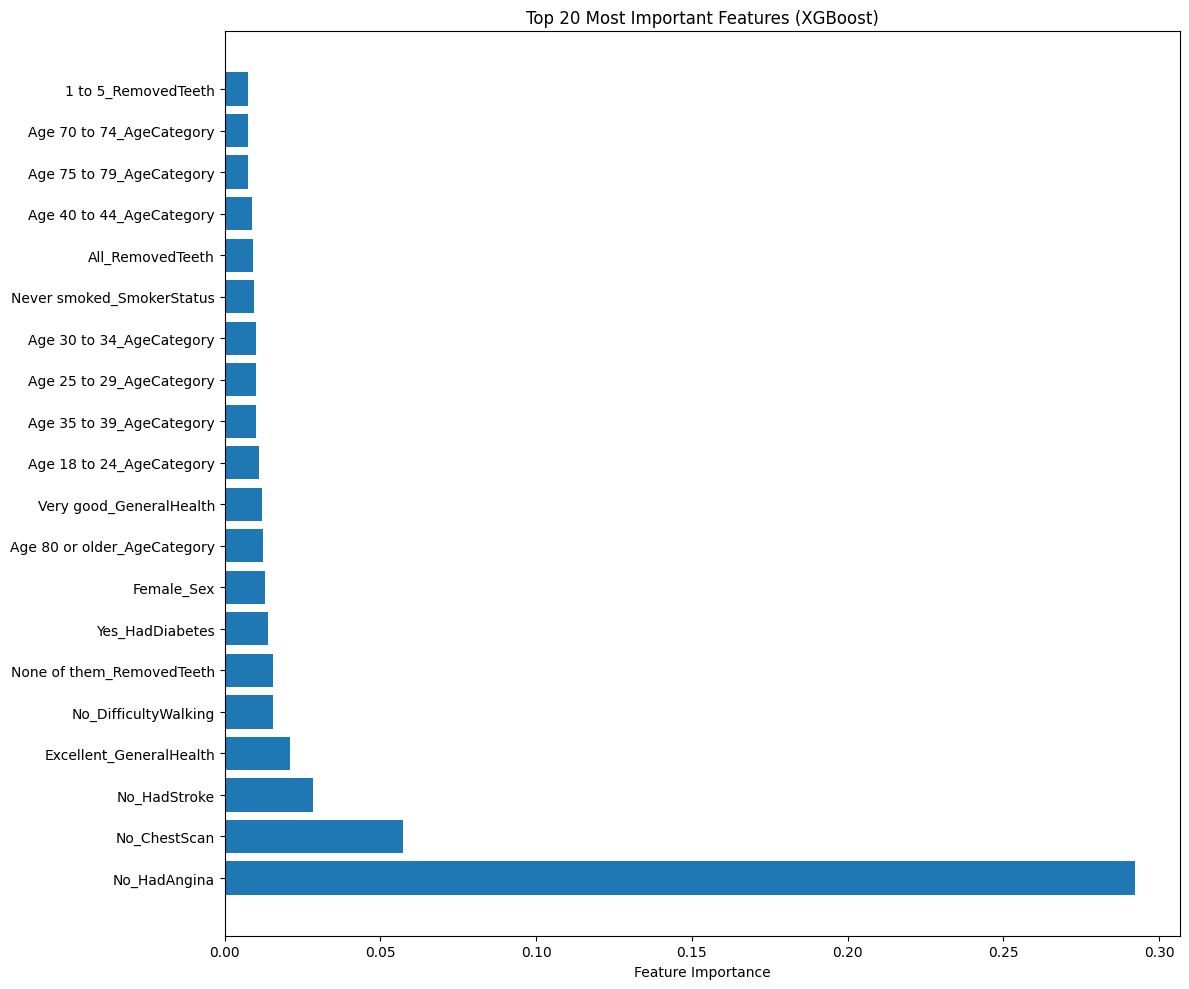


Top 20 Feature Importances:
No_HadAngina: 0.2921
No_ChestScan: 0.0572
No_HadStroke: 0.0283
Excellent_GeneralHealth: 0.0210
No_DifficultyWalking: 0.0156
None of them_RemovedTeeth: 0.0153
Yes_HadDiabetes: 0.0139
Female_Sex: 0.0128
Age 80 or older_AgeCategory: 0.0123
Very good_GeneralHealth: 0.0119
Age 18 to 24_AgeCategory: 0.0109
Age 35 to 39_AgeCategory: 0.0102
Age 25 to 29_AgeCategory: 0.0100
Age 30 to 34_AgeCategory: 0.0100
Never smoked_SmokerStatus: 0.0093
All_RemovedTeeth: 0.0090
Age 40 to 44_AgeCategory: 0.0088
Age 75 to 79_AgeCategory: 0.0076
Age 70 to 74_AgeCategory: 0.0074
1 to 5_RemovedTeeth: 0.0074


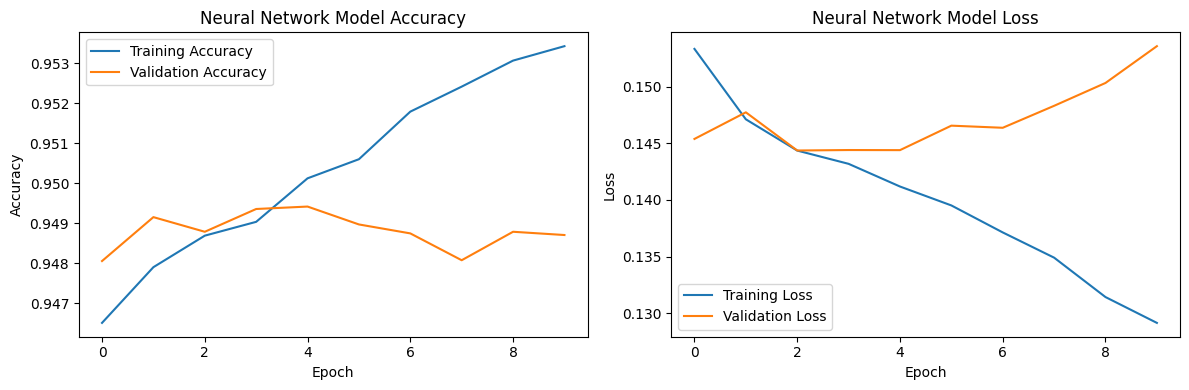

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/moiz/Downloads/heart_2022_no_nans.csv')

# Separate features and target
X = df.drop('HadHeartAttack', axis=1)
y = df['HadHeartAttack']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Simplify feature names
X_encoded.columns = X_encoded.columns.str.replace(r'_[YN]$', '', regex=True)  # Remove '_Y' or '_N' suffixes
X_encoded.columns = X_encoded.columns.str.replace(r'^(.+)_(.+)$', r'\2_\1', regex=True)  # Move category to front

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and compile the neural network model
nn_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Train the neural network model
nn_history = nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, 
                          validation_data=(X_test_scaled, y_test), verbose=1)

# Define and train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Make predictions with both models
nn_predictions = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
xgb_predictions = xgb_model.predict(X_test_scaled)

# Print results
print("\nNeural Network Results:")
print(classification_report(y_test, nn_predictions))

print("\nXGBoost Results:")
print(classification_report(y_test, xgb_predictions))

# Plot feature importance for XGBoost
plt.figure(figsize=(12, 10))
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
top_20_idx = sorted_idx[-20:]  # Get indices of top 20 features

pos = np.arange(len(top_20_idx))
plt.barh(pos, feature_importance[top_20_idx], align='center')
plt.yticks(pos, X_train.columns[top_20_idx], fontsize=10)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

# Print top 20 feature importances
print("\nTop 20 Feature Importances:")
for i in reversed(top_20_idx):
    print(f"{X_train.columns[i]}: {feature_importance[i]:.4f}")

# Plot training history for Neural Network
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(nn_history.history['accuracy'], label='Training Accuracy')
plt.plot(nn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nn_history.history['loss'], label='Training Loss')
plt.plot(nn_history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Categorical columns: Index(['State', 'Sex', 'GeneralHealth', 'LastCheckupTime',
       'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
       'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
       'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')
Epoch 1/10
12302/12302 [==============================] - 8s 669us/step - loss: 0.1536 - accuracy: 0.9463 - val_loss: 0.1454 - val_accuracy: 0.9492
Epoch 2/10
12302/12302 [==============================] - 8s 661us/step - loss: 0.1475 - accuracy: 0.9479 - val_loss: 0.1461 - val_accuracy: 0.9476
Ep

/Users/moiz/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:54:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


1538/1538 [==============================] - 0s 267us/step

Neural Network Results:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     46573
           1       0.58      0.11      0.18      2632

    accuracy                           0.95     49205
   macro avg       0.77      0.55      0.58     49205
weighted avg       0.93      0.95      0.93     49205


XGBoost Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     46573
           1       0.55      0.24      0.33      2632

    accuracy                           0.95     49205
   macro avg       0.75      0.61      0.65     49205
weighted avg       0.94      0.95      0.94     49205


Random Forest Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     46573
           1       0.58      0.18      0.27      2632

    accuracy                           0.95     49205
  

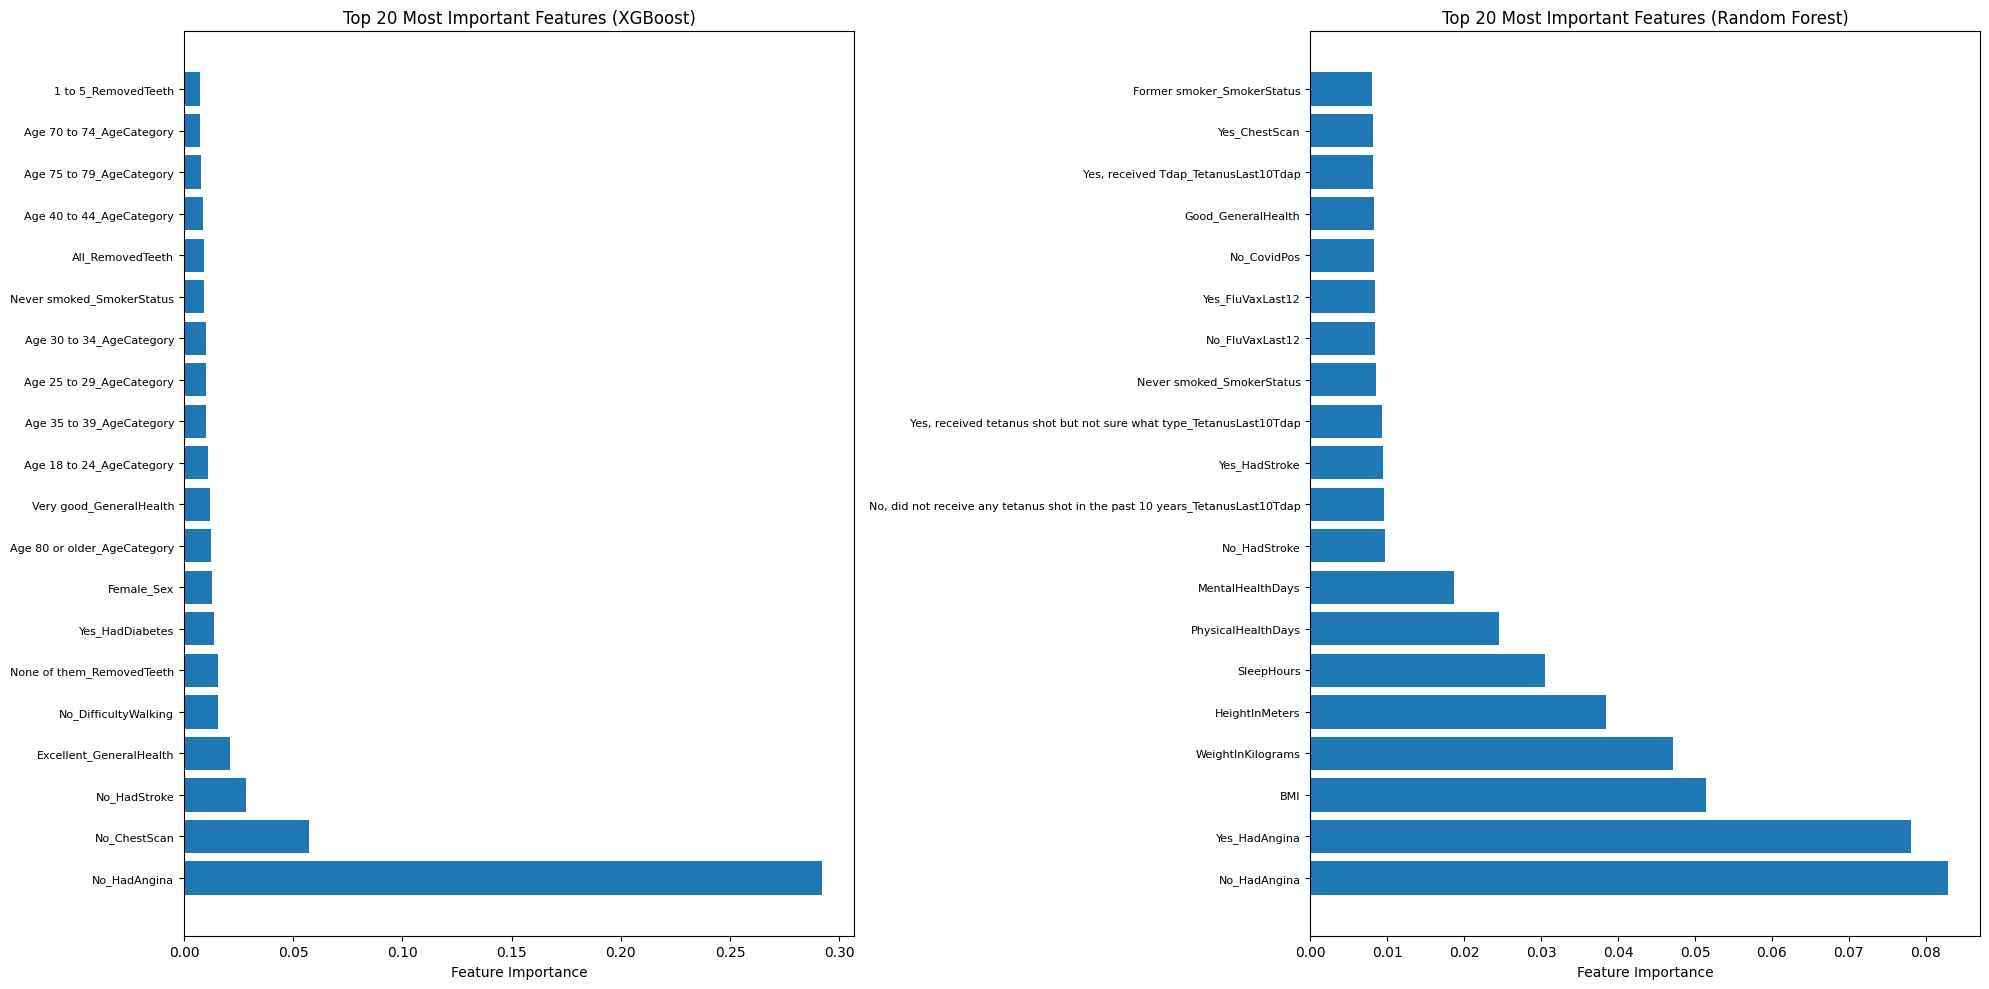


Top 20 Feature Importances (XGBoost):
No_HadAngina: 0.2921
No_ChestScan: 0.0572
No_HadStroke: 0.0283
Excellent_GeneralHealth: 0.0210
No_DifficultyWalking: 0.0156
None of them_RemovedTeeth: 0.0153
Yes_HadDiabetes: 0.0139
Female_Sex: 0.0128
Age 80 or older_AgeCategory: 0.0123
Very good_GeneralHealth: 0.0119
Age 18 to 24_AgeCategory: 0.0109
Age 35 to 39_AgeCategory: 0.0102
Age 25 to 29_AgeCategory: 0.0100
Age 30 to 34_AgeCategory: 0.0100
Never smoked_SmokerStatus: 0.0093
All_RemovedTeeth: 0.0090
Age 40 to 44_AgeCategory: 0.0088
Age 75 to 79_AgeCategory: 0.0076
Age 70 to 74_AgeCategory: 0.0074
1 to 5_RemovedTeeth: 0.0074

Top 20 Feature Importances (Random Forest):
No_HadAngina: 0.0829
Yes_HadAngina: 0.0780
BMI: 0.0515
WeightInKilograms: 0.0472
HeightInMeters: 0.0385
SleepHours: 0.0306
PhysicalHealthDays: 0.0246
MentalHealthDays: 0.0187
No_HadStroke: 0.0097
No, did not receive any tetanus shot in the past 10 years_TetanusLast10Tdap: 0.0096
Yes_HadStroke: 0.0095
Yes, received tetanus shot 

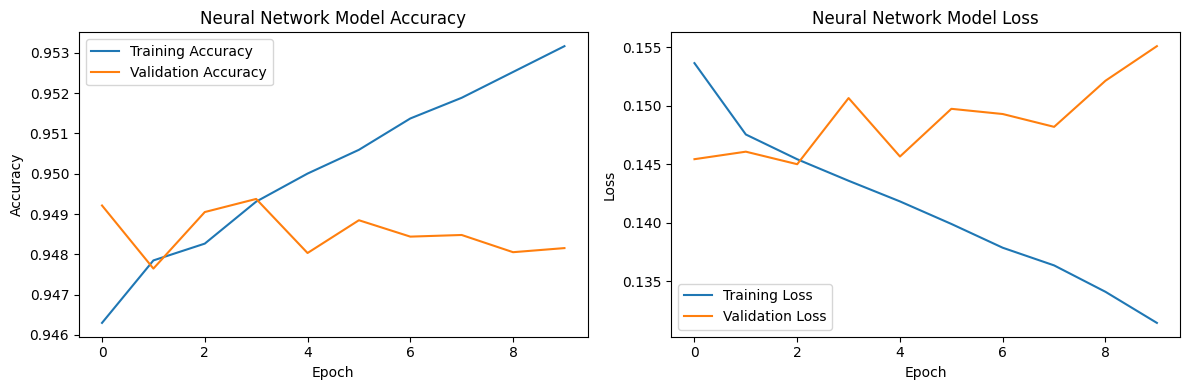

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/moiz/Downloads/heart_2022_no_nans.csv')

# Separate features and target
X = df.drop('HadHeartAttack', axis=1)
y = df['HadHeartAttack']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Simplify feature names
X_encoded.columns = X_encoded.columns.str.replace(r'_[YN]$', '', regex=True)
X_encoded.columns = X_encoded.columns.str.replace(r'^(.+)_(.+)$', r'\2_\1', regex=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural Network Model
nn_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_history = nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, 
                          validation_data=(X_test_scaled, y_test), verbose=1)

# XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
nn_predictions = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
xgb_predictions = xgb_model.predict(X_test_scaled)
rf_predictions = rf_model.predict(X_test_scaled)

# Print results
print("\nNeural Network Results:")
print(classification_report(y_test, nn_predictions))

print("\nXGBoost Results:")
print(classification_report(y_test, xgb_predictions))

print("\nRandom Forest Results:")
print(classification_report(y_test, rf_predictions))

# Plot feature importance for XGBoost and Random Forest
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

def plot_feature_importance(model, ax, title):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    top_20_idx = sorted_idx[-20:]
    pos = np.arange(len(top_20_idx))
    ax.barh(pos, feature_importance[top_20_idx], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(X_train.columns[top_20_idx], fontsize=8)
    ax.set_xlabel('Feature Importance')
    ax.set_title(title)
    ax.invert_yaxis()

plot_feature_importance(xgb_model, ax1, 'Top 20 Most Important Features (XGBoost)')
plot_feature_importance(rf_model, ax2, 'Top 20 Most Important Features (Random Forest)')

plt.tight_layout()
plt.show()

# Print top 20 feature importances for both models
print("\nTop 20 Feature Importances (XGBoost):")
for i in reversed(np.argsort(xgb_model.feature_importances_)[-20:]):
    print(f"{X_train.columns[i]}: {xgb_model.feature_importances_[i]:.4f}")

print("\nTop 20 Feature Importances (Random Forest):")
for i in reversed(np.argsort(rf_model.feature_importances_)[-20:]):
    print(f"{X_train.columns[i]}: {rf_model.feature_importances_[i]:.4f}")

# Plot training history for Neural Network
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(nn_history.history['accuracy'], label='Training Accuracy')
plt.plot(nn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nn_history.history['loss'], label='Training Loss')
plt.plot(nn_history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Categorical columns: Index(['State', 'Sex', 'GeneralHealth', 'LastCheckupTime',
       'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
       'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
       'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

Random Forest Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     46573
           1       0.58      0.18      0.27      2632

    accuracy                           0.95     49205
   macro avg       0.77      0.59      0.62     49205
we

/var/folders/fd/n_lksln53nj3d_0j7209_rrw0000gn/T/ipykernel_2325/3553552428.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  age_df[col] = X[col].mean()
/var/folders/fd/n_lksln53nj3d_0j7209_rrw0000gn/T/ipykernel_2325/3553552428.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  age_df[col] = X[col].mean()
/var/folders/fd/n_lksln53nj3d_0j7209_rrw0000gn/T/ipykernel_2325/3553552428.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

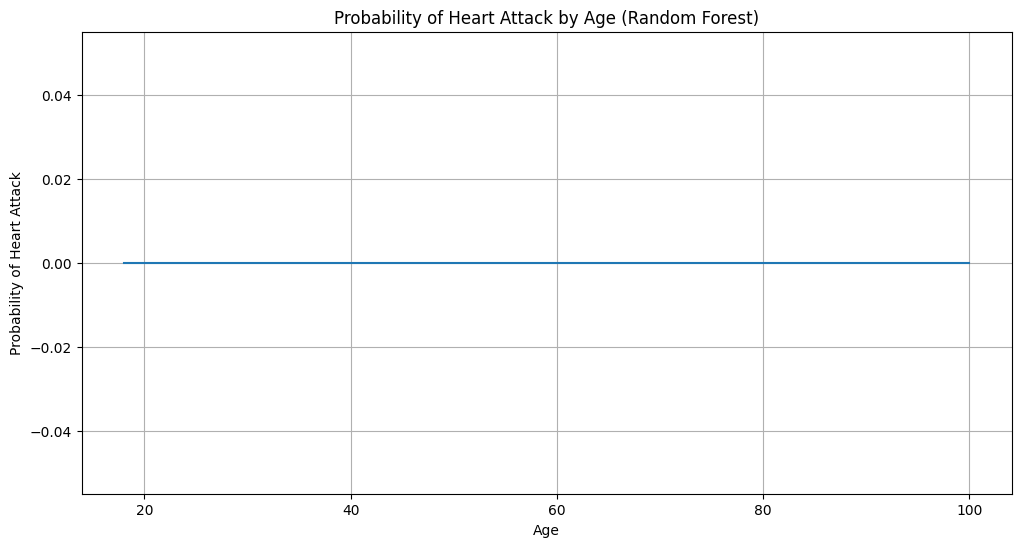

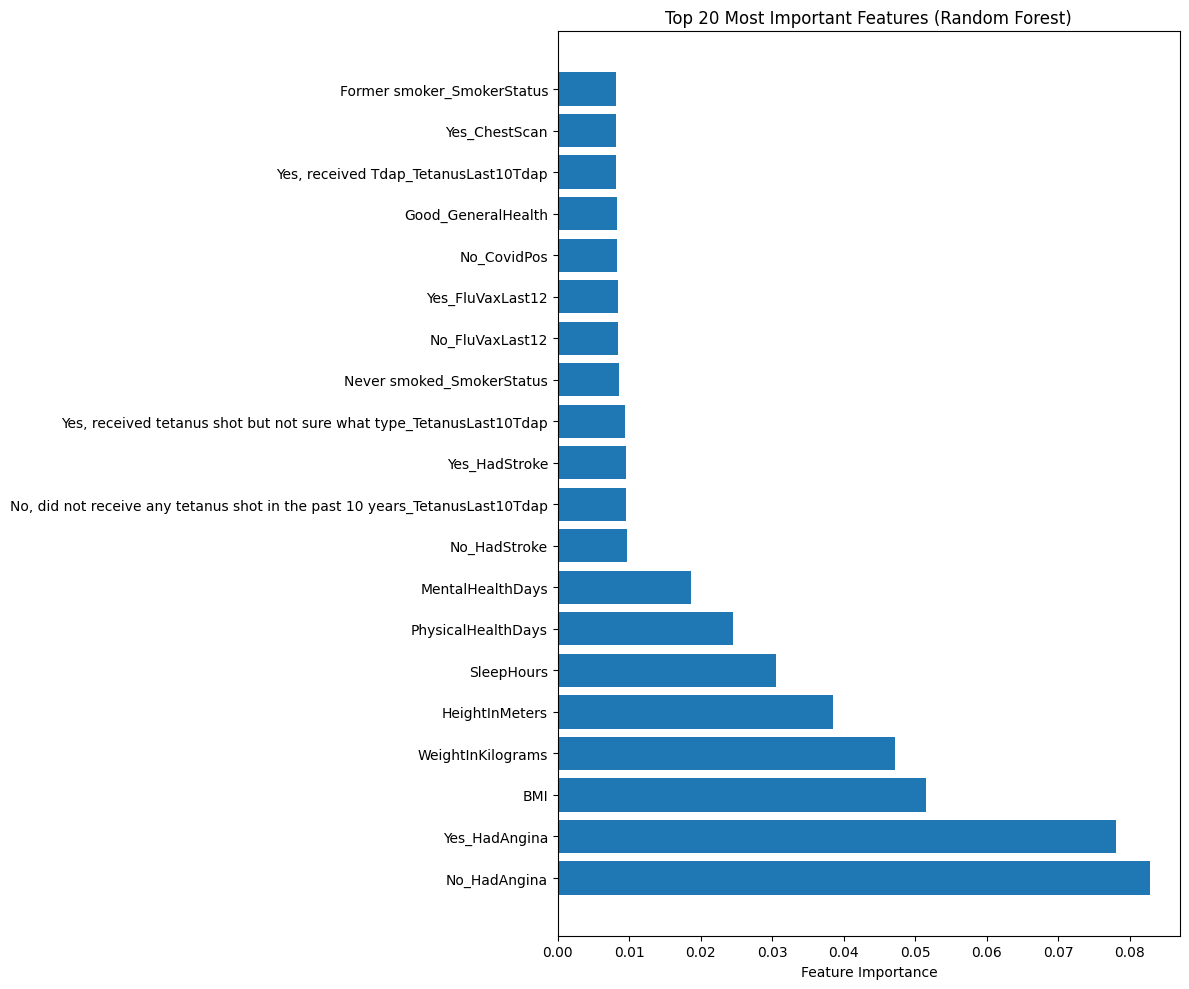


Top 20 Feature Importances (Random Forest):
No_HadAngina: 0.0829
Yes_HadAngina: 0.0780
BMI: 0.0515
WeightInKilograms: 0.0472
HeightInMeters: 0.0385
SleepHours: 0.0306
PhysicalHealthDays: 0.0246
MentalHealthDays: 0.0187
No_HadStroke: 0.0097
No, did not receive any tetanus shot in the past 10 years_TetanusLast10Tdap: 0.0096
Yes_HadStroke: 0.0095
Yes, received tetanus shot but not sure what type_TetanusLast10Tdap: 0.0094
Never smoked_SmokerStatus: 0.0085
No_FluVaxLast12: 0.0084
Yes_FluVaxLast12: 0.0084
No_CovidPos: 0.0083
Good_GeneralHealth: 0.0082
Yes, received Tdap_TetanusLast10Tdap: 0.0081
Yes_ChestScan: 0.0081
Former smoker_SmokerStatus: 0.0081


In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/moiz/Downloads/heart_2022_no_nans.csv')

# Separate features and target
X = df.drop('HadHeartAttack', axis=1)
y = df['HadHeartAttack']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Simplify feature names
X_encoded.columns = X_encoded.columns.str.replace(r'_[YN]$', '', regex=True)
X_encoded.columns = X_encoded.columns.str.replace(r'^(.+)_(.+)$', r'\2_\1', regex=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)

# Print results
print("\nRandom Forest Results:")
print(classification_report(y_test, rf_predictions))

# Plot Random Forest predictions by age
def plot_rf_age_predictions(model, X, scaler):
    # Find the age column
    age_col = [col for col in X.columns if 'age' in col.lower()][0]
    
    # Create a DataFrame with age range
    age_df = pd.DataFrame({age_col: range(18, 101)})
    
    # Create dummy variables for all other features (use mode for categorical, mean for numerical)
    for col in X.columns:
        if col != age_col:
            if X[col].dtype == 'object':
                age_df[col] = X[col].mode()[0]
            else:
                age_df[col] = X[col].mean()
    
    # Ensure age_df has the same columns as X, in the same order
    age_df = age_df.reindex(columns=X.columns, fill_value=0)
    
    # Scale the age_df
    age_df_scaled = scaler.transform(age_df)
    
    # Get predictions
    predictions = model.predict_proba(age_df_scaled)[:, 1]
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(age_df[age_col], predictions)
    plt.title('Probability of Heart Attack by Age (Random Forest)')
    plt.xlabel('Age')
    plt.ylabel('Probability of Heart Attack')
    plt.grid(True)
    plt.show()

# Plot Random Forest predictions by age
plot_rf_age_predictions(rf_model, X_encoded, scaler)

# Plot feature importance for Random Forest
plt.figure(figsize=(12, 10))
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
top_20_idx = sorted_idx[-20:]
pos = np.arange(len(top_20_idx))
plt.barh(pos, feature_importance[top_20_idx], align='center')
plt.yticks(pos, X_train.columns[top_20_idx], fontsize=10)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print top 20 feature importances
print("\nTop 20 Feature Importances (Random Forest):")
for i in reversed(top_20_idx):
    print(f"{X_train.columns[i]}: {feature_importance[i]:.4f}")

Categorical columns: Index(['State', 'Sex', 'GeneralHealth', 'LastCheckupTime',
       'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
       'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
       'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

Random Forest Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     46573
           1       0.58      0.18      0.27      2632

    accuracy                           0.95     49205
   macro avg       0.77      0.59      0.62     49205
we

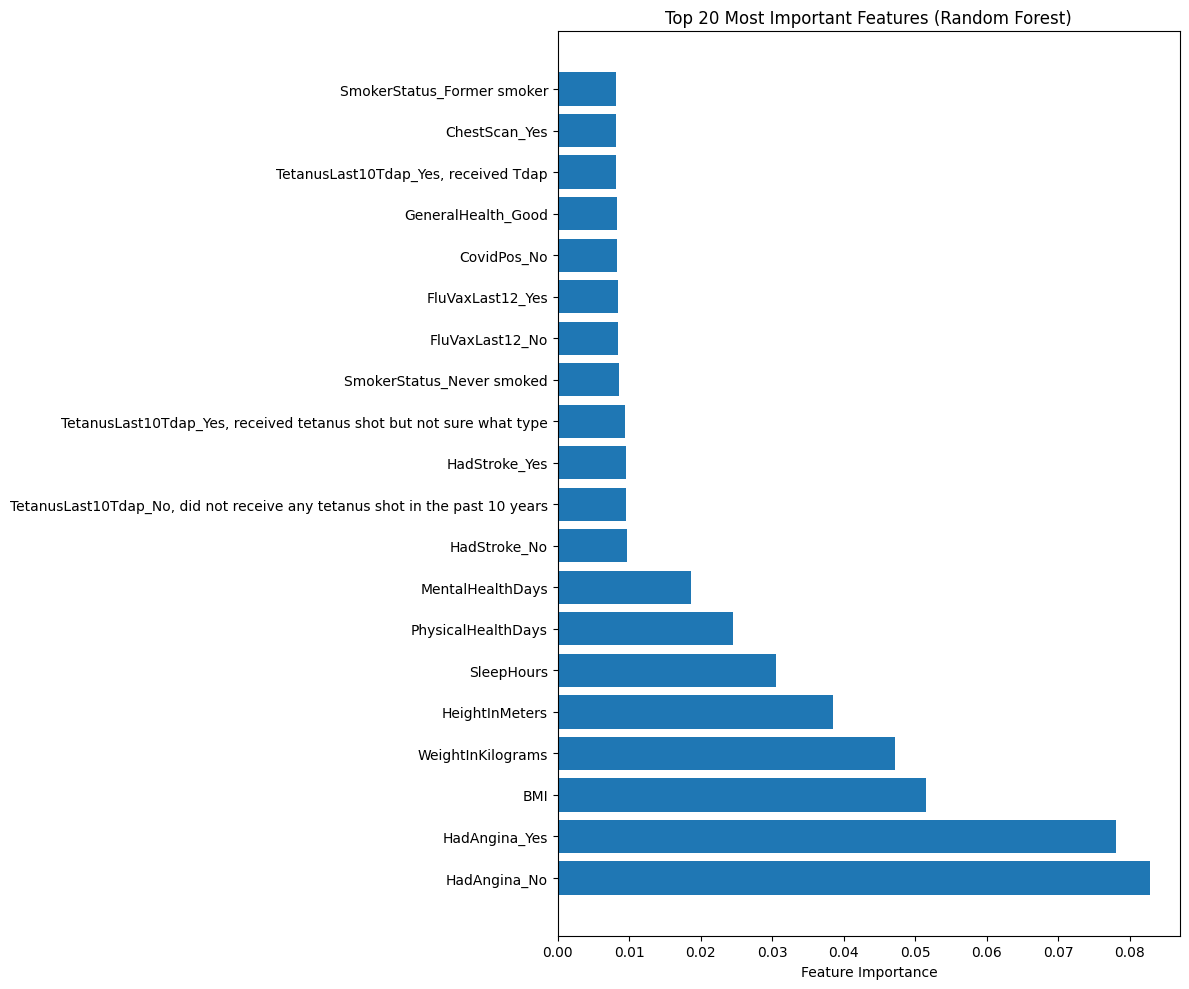


Top 20 Feature Importances:
HadAngina_No: 0.0829
HadAngina_Yes: 0.0780
BMI: 0.0515
WeightInKilograms: 0.0472
HeightInMeters: 0.0385
SleepHours: 0.0306
PhysicalHealthDays: 0.0246
MentalHealthDays: 0.0187
HadStroke_No: 0.0097
TetanusLast10Tdap_No, did not receive any tetanus shot in the past 10 years: 0.0096
HadStroke_Yes: 0.0095
TetanusLast10Tdap_Yes, received tetanus shot but not sure what type: 0.0094
SmokerStatus_Never smoked: 0.0085
FluVaxLast12_No: 0.0084
FluVaxLast12_Yes: 0.0084
CovidPos_No: 0.0083
GeneralHealth_Good: 0.0082
TetanusLast10Tdap_Yes, received Tdap: 0.0081
ChestScan_Yes: 0.0081
SmokerStatus_Former smoker: 0.0081


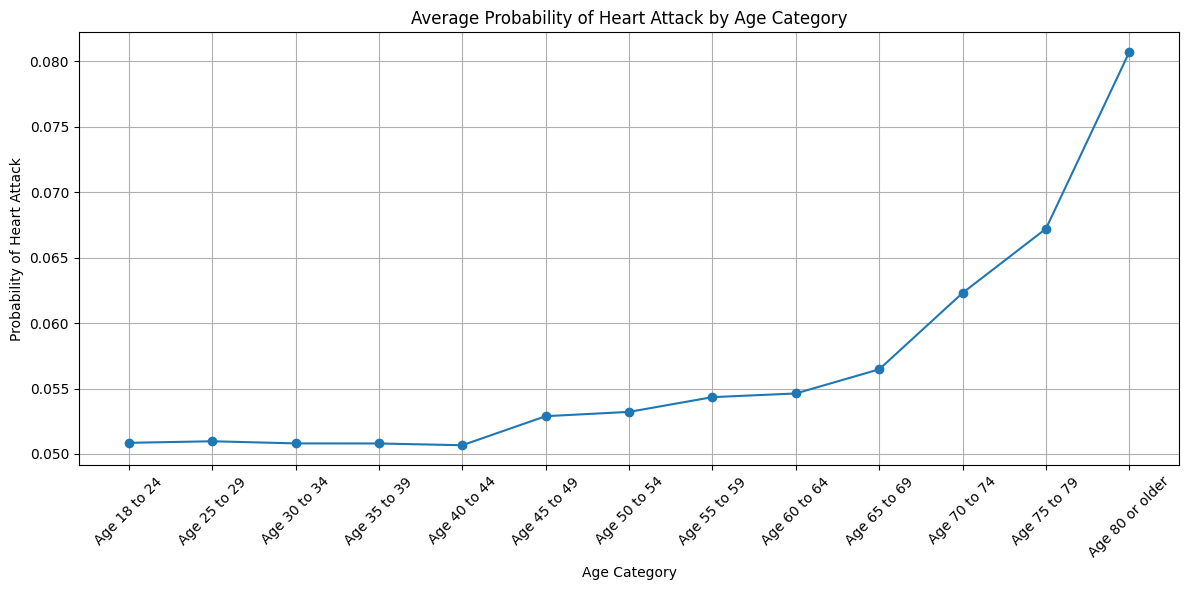

/var/folders/fd/n_lksln53nj3d_0j7209_rrw0000gn/T/ipykernel_2325/2121300331.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = X_binned.groupby('bins')


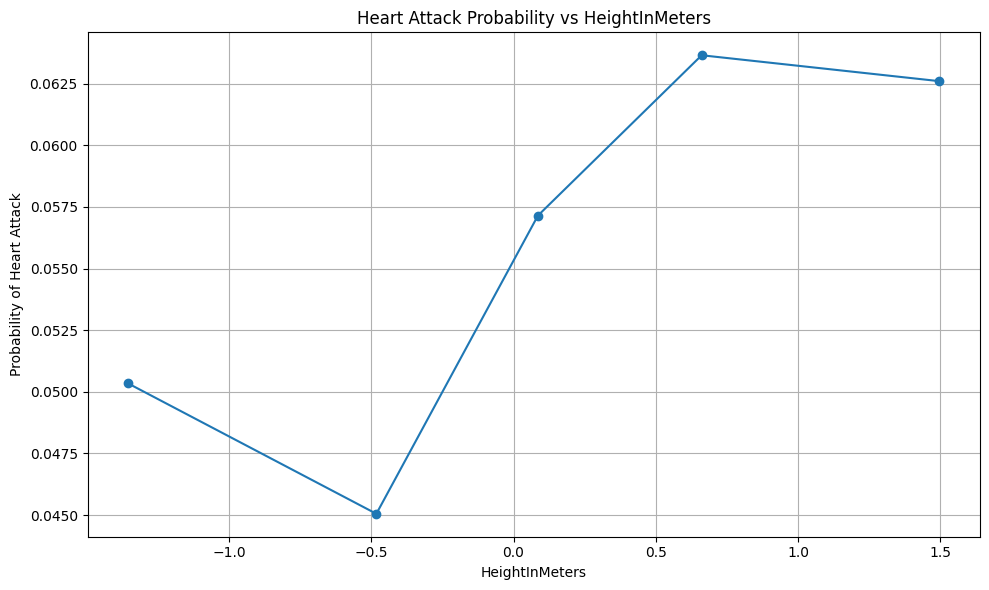

/var/folders/fd/n_lksln53nj3d_0j7209_rrw0000gn/T/ipykernel_2325/2121300331.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = X_binned.groupby('bins')


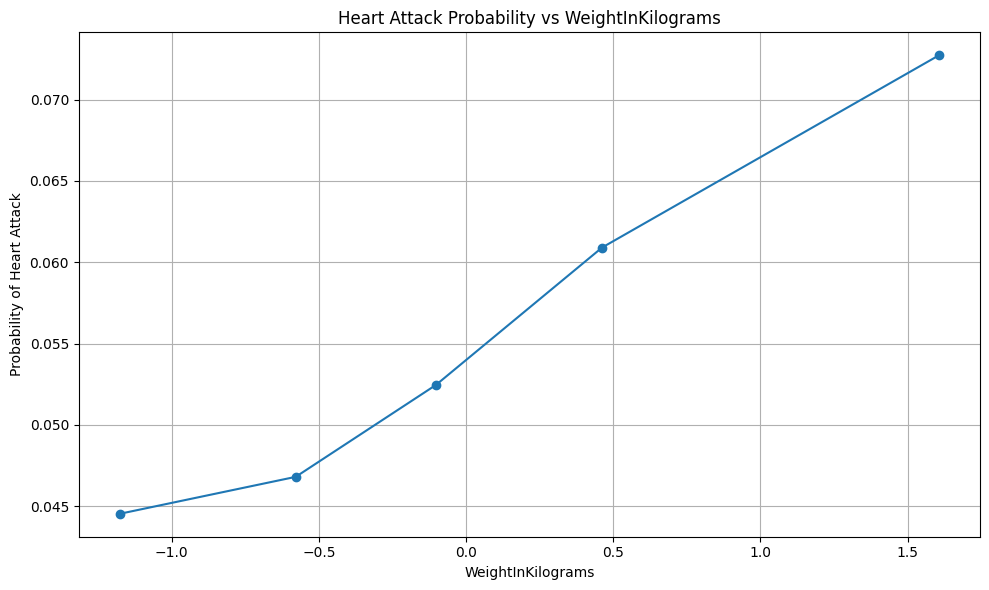

/var/folders/fd/n_lksln53nj3d_0j7209_rrw0000gn/T/ipykernel_2325/2121300331.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = X_binned.groupby('bins')


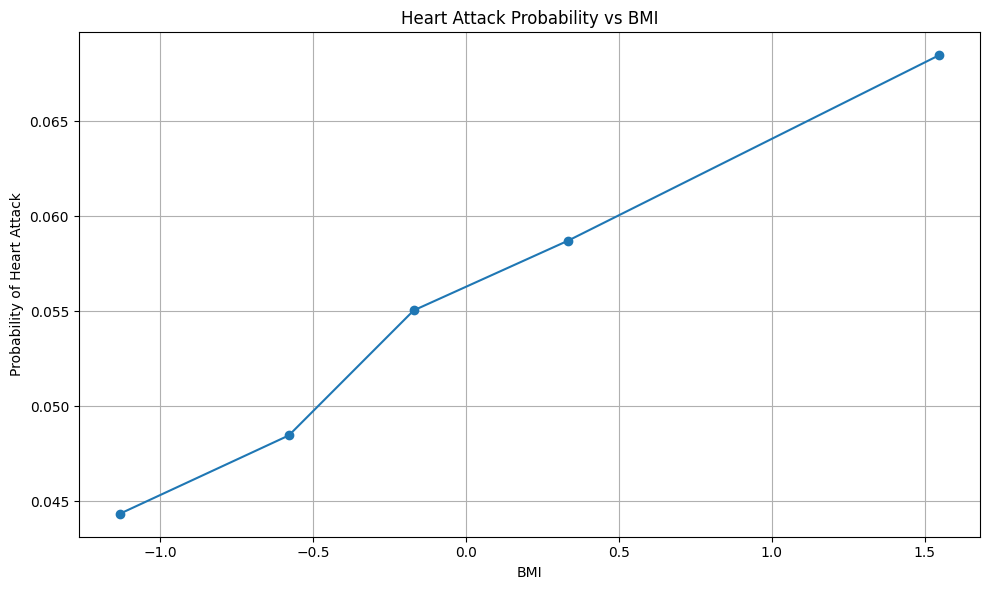

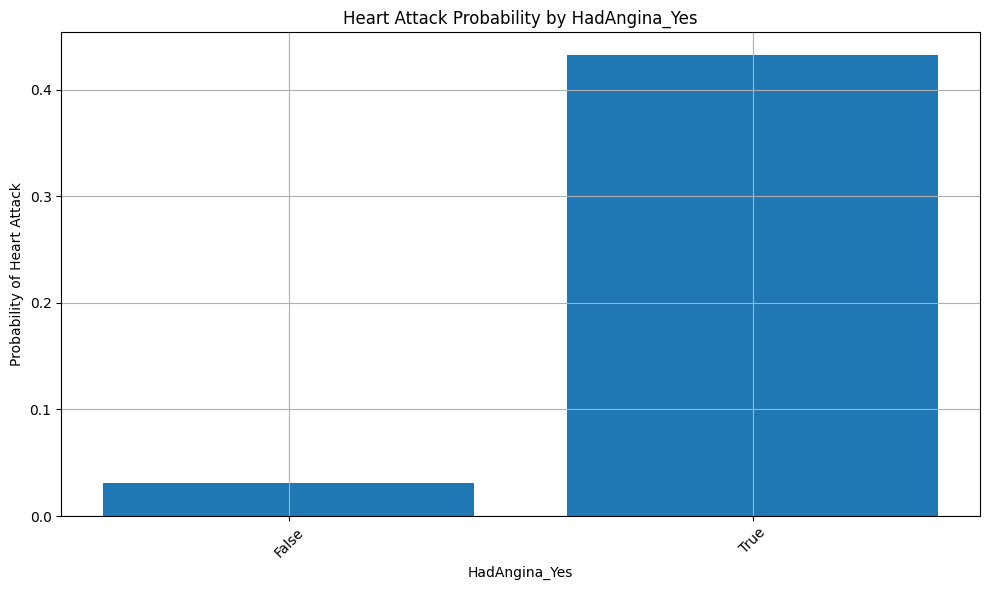

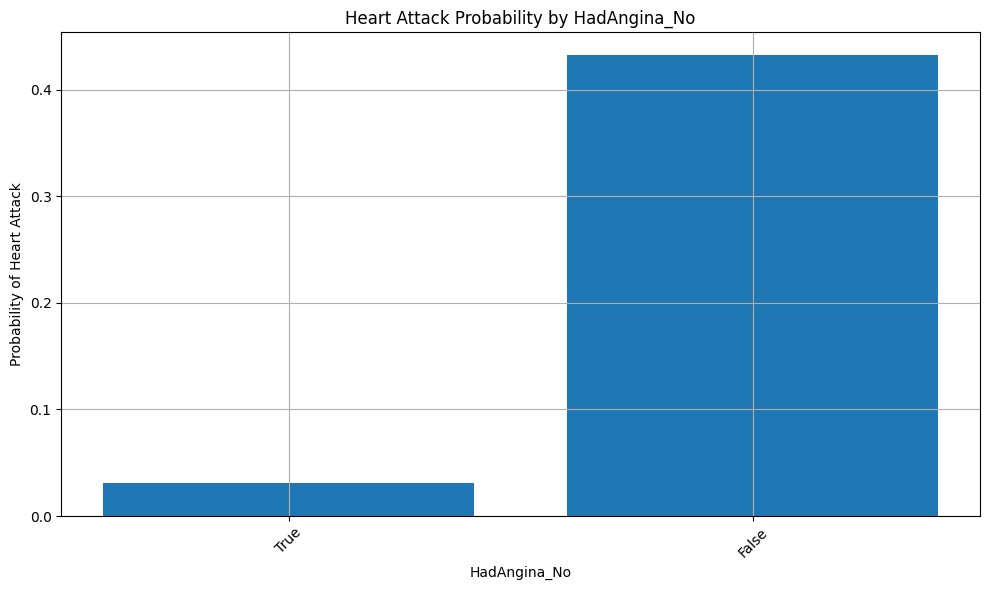

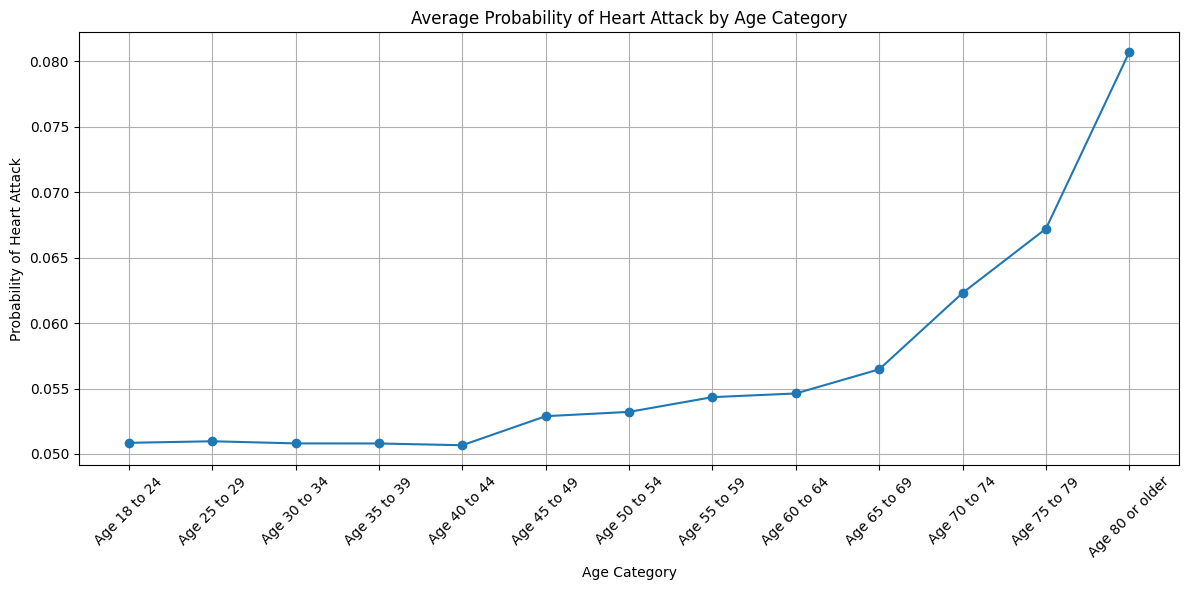

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/moiz/Downloads/heart_2022_no_nans.csv')

# Separate features and target
X = df.drop('HadHeartAttack', axis=1)
y = df['HadHeartAttack']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale the numerical features
scaler = StandardScaler()
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Print results
print("\nRandom Forest Results:")
print(classification_report(y_test, rf_predictions))
print(f"ROC AUC Score: {roc_auc_score(y_test, rf_proba):.4f}")

# Plot feature importance
plt.figure(figsize=(12, 10))
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
top_20_idx = sorted_idx[-20:]
pos = np.arange(len(top_20_idx))
plt.barh(pos, feature_importance[top_20_idx], align='center')
plt.yticks(pos, X_train.columns[top_20_idx], fontsize=10)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print top 20 feature importances
print("\nTop 20 Feature Importances:")
for i in reversed(top_20_idx):
    print(f"{X_train.columns[i]}: {feature_importance[i]:.4f}")

# Plot heart attack probability by age category
age_categories = [col for col in X_train.columns if col.startswith('AgeCategory_')]
age_probs = []

for age_cat in age_categories:
    X_age = X_test_scaled.copy()
    X_age[age_categories] = 0
    X_age[age_cat] = 1
    age_prob = rf_model.predict_proba(X_age)[:, 1].mean()
    age_probs.append(age_prob)

plt.figure(figsize=(12, 6))
plt.plot(range(len(age_categories)), age_probs, marker='o')
plt.xticks(range(len(age_categories)), [cat.split('_')[1] for cat in age_categories], rotation=45)
plt.title('Average Probability of Heart Attack by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Probability of Heart Attack')
plt.grid(True)
plt.tight_layout()
plt.show()


# Analyze impact of other important features
top_features = X_train.columns[top_20_idx][-5:]  # Top 5 features

for feature in top_features:
    if feature in numerical_columns:
        # For numerical features, create bins
        X_binned = pd.DataFrame()
        X_binned[feature] = X_test_scaled[feature]
        X_binned['bins'] = pd.qcut(X_binned[feature], q=5)
        grouped = X_binned.groupby('bins')
        means = grouped[feature].mean()
        
        probs = []
        for _, group in grouped:
            X_group = X_test_scaled[X_test_scaled.index.isin(group.index)]
            prob = rf_model.predict_proba(X_group)[:, 1].mean()
            probs.append(prob)
        
        plt.figure(figsize=(10, 6))
        plt.plot(means, probs, marker='o')
        plt.title(f'Heart Attack Probability vs {feature}')
        plt.xlabel(feature)
        plt.ylabel('Probability of Heart Attack')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        # For categorical features, use categories directly
        categories = X_test_scaled[feature].unique()
        probs = []
        for category in categories:
            X_cat = X_test_scaled[X_test_scaled[feature] == category]
            prob = rf_model.predict_proba(X_cat)[:, 1].mean()
            probs.append(prob)
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(categories)), probs)
        plt.xticks(range(len(categories)), categories, rotation=45)
        plt.title(f'Heart Attack Probability by {feature}')
        plt.xlabel(feature)
        plt.ylabel('Probability of Heart Attack')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Plot heart attack probability by age category
age_categories = [col for col in X_train.columns if col.startswith('AgeCategory_')]
age_probs = []

for age_cat in age_categories:
    X_age = X_test_scaled.copy()
    X_age[age_categories] = 0
    X_age[age_cat] = 1
    age_prob = rf_model.predict_proba(X_age)[:, 1].mean()
    age_probs.append(age_prob)

plt.figure(figsize=(12, 6))
plt.plot(range(len(age_categories)), age_probs, marker='o')
plt.xticks(range(len(age_categories)), [cat.split('_')[1] for cat in age_categories], rotation=45)
plt.title('Average Probability of Heart Attack by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Probability of Heart Attack')
plt.grid(True)
plt.tight_layout()
plt.show()


LOGISTIC REGRESSION MODEL FOR HEART ATTACK PREDICTION

Categorical columns: Index(['State', 'Sex', 'GeneralHealth', 'LastCheckupTime',
       'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
       'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
       'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     46573
           1       0.55      0.25      0.35      2632

    accuracy                           0.95     

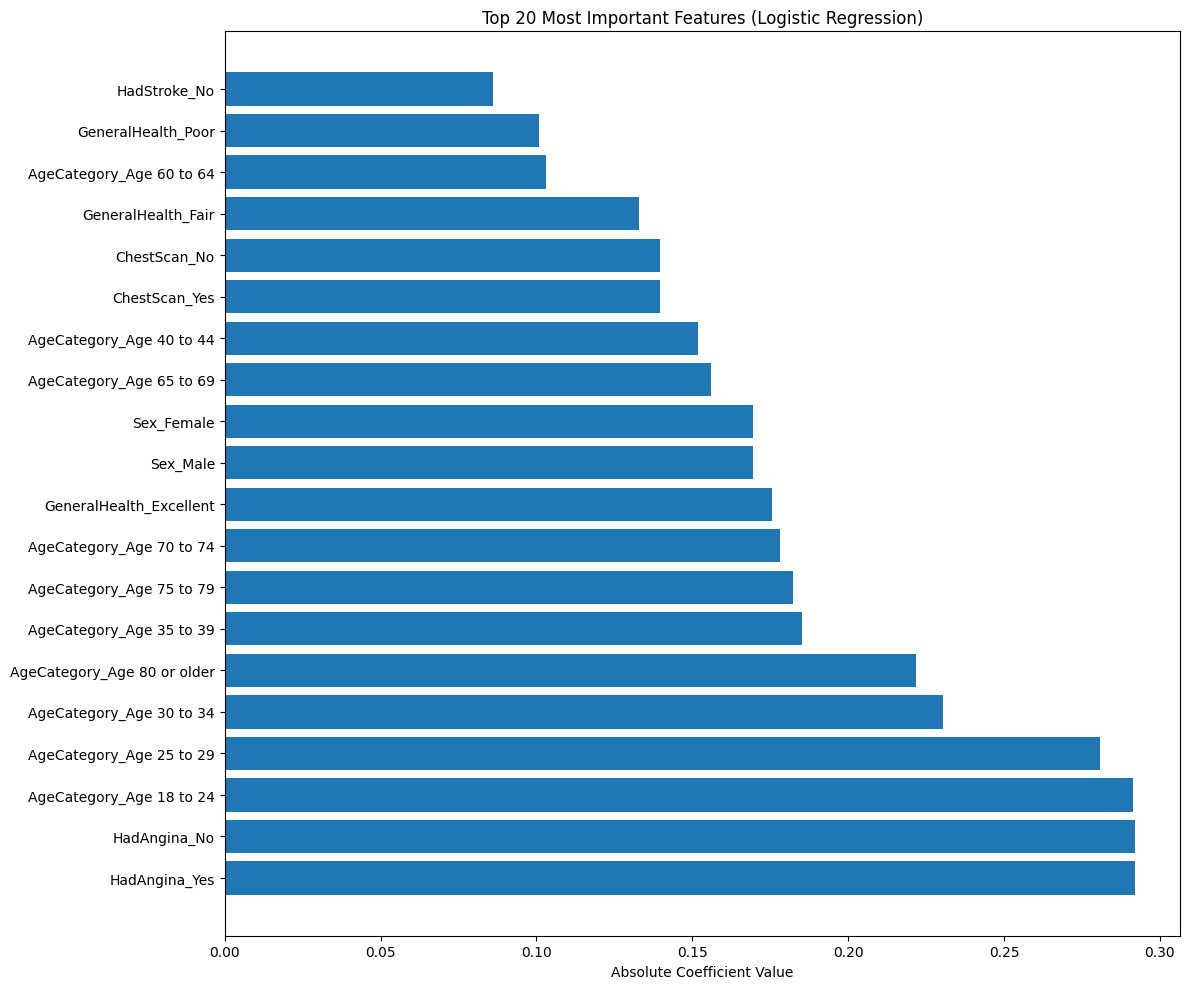


Top 20 Feature Importances (Absolute Coefficient Values):
HadAngina_Yes: 0.2919
HadAngina_No: 0.2919
AgeCategory_Age 18 to 24: 0.2914
AgeCategory_Age 25 to 29: 0.2807
AgeCategory_Age 30 to 34: 0.2303
AgeCategory_Age 80 or older: 0.2217
AgeCategory_Age 35 to 39: 0.1854
AgeCategory_Age 75 to 79: 0.1824
AgeCategory_Age 70 to 74: 0.1781
GeneralHealth_Excellent: 0.1756
Sex_Male: 0.1694
Sex_Female: 0.1694
AgeCategory_Age 65 to 69: 0.1562
AgeCategory_Age 40 to 44: 0.1520
ChestScan_Yes: 0.1397
ChestScan_No: 0.1397
GeneralHealth_Fair: 0.1330
AgeCategory_Age 60 to 64: 0.1032
GeneralHealth_Poor: 0.1009
HadStroke_No: 0.0860


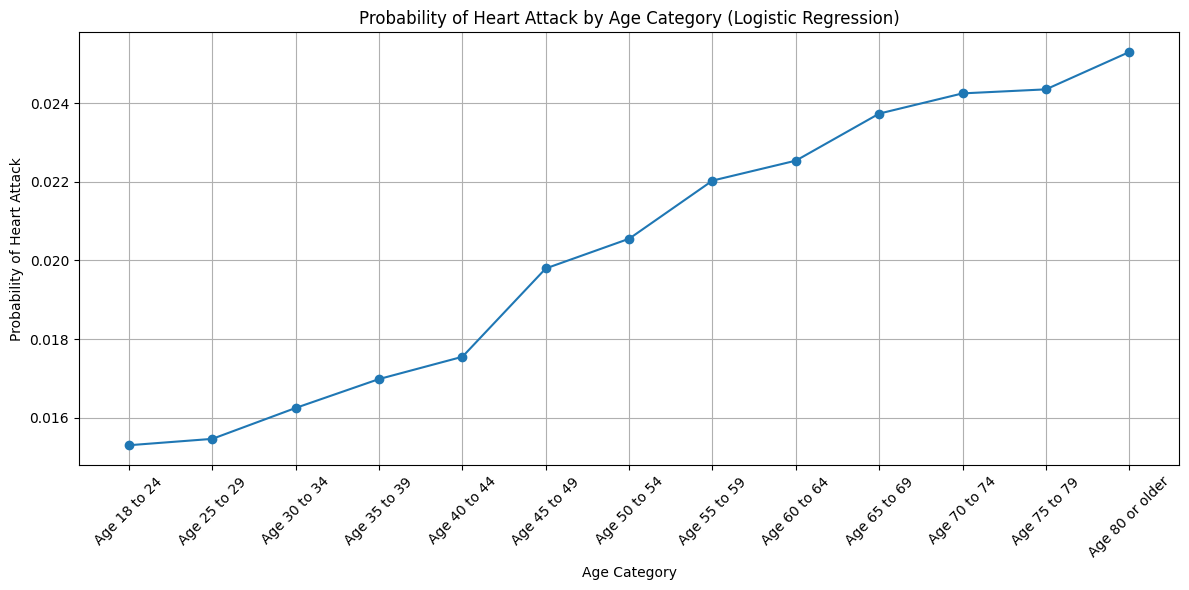


Logistic Regression Analysis Complete



In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*50)
print("LOGISTIC REGRESSION MODEL FOR HEART ATTACK PREDICTION")
print("="*50 + "\n")

# Load the dataset
df = pd.read_csv('/Users/moiz/Downloads/heart_2022_no_nans.csv')

# Separate features and target
X = df.drop('HadHeartAttack', axis=1)
y = df['HadHeartAttack']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression Model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test_scaled)
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Print results
print("\nLogistic Regression Results:")
print(classification_report(y_test, lr_predictions))
print(f"ROC AUC Score: {roc_auc_score(y_test, lr_proba):.4f}")

# Plot feature importance (coefficients)
plt.figure(figsize=(12, 10))
feature_importance = np.abs(lr_model.coef_[0])
sorted_idx = np.argsort(feature_importance)
top_20_idx = sorted_idx[-20:]
pos = np.arange(len(top_20_idx))
plt.barh(pos, feature_importance[top_20_idx], align='center')
plt.yticks(pos, X_train.columns[top_20_idx], fontsize=10)
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 20 Most Important Features (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print top 20 feature importances
print("\nTop 20 Feature Importances (Absolute Coefficient Values):")
for i in reversed(top_20_idx):
    print(f"{X_train.columns[i]}: {feature_importance[i]:.4f}")

# Plot probability of heart attack by age category
age_categories = [col for col in X_train.columns if col.startswith('AgeCategory_')]
age_probs = []

for age_cat in age_categories:
    X_age = np.zeros((1, X_train_scaled.shape[1]))
    age_index = X_train.columns.get_loc(age_cat)
    X_age[0, age_index] = 1
    age_prob = lr_model.predict_proba(X_age)[0, 1]
    age_probs.append(age_prob)

plt.figure(figsize=(12, 6))
plt.plot(range(len(age_categories)), age_probs, marker='o')
plt.xticks(range(len(age_categories)), [cat.split('_')[1] for cat in age_categories], rotation=45)
plt.title('Probability of Heart Attack by Age Category (Logistic Regression)')
plt.xlabel('Age Category')
plt.ylabel('Probability of Heart Attack')
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze impact of top 5 numerical features
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
top_numerical_features = [col for col in X_train.columns[top_20_idx] if col in numerical_features][:5]

for feature in top_numerical_features:
    feature_index = X_train.columns.get_loc(feature)
    X_feature = np.zeros((100, X_train_scaled.shape[1]))
    X_feature[:, feature_index] = np.linspace(X_train_scaled[:, feature_index].min(), 
                                              X_train_scaled[:, feature_index].max(), 
                                              100)
    
    probs = lr_model.predict_proba(X_feature)[:, 1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(X_feature[:, feature_index], probs)
    plt.title(f'Heart Attack Probability vs {feature} (Logistic Regression)')
    plt.xlabel(feature)
    plt.ylabel('Probability of Heart Attack')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\nLogistic Regression Analysis Complete")
print("="*50 + "\n")

Categorical columns: Index(['State', 'Sex', 'GeneralHealth', 'LastCheckupTime',
       'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
       'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
       'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

LOGISTIC REGRESSION MODEL FOR HEART ATTACK PREDICTION


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     46573
           1       0.55      0.25      0.35      2632

    accuracy                           0.95     

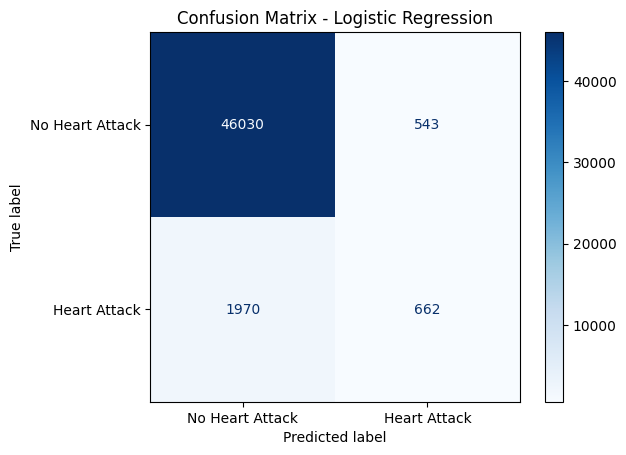


RANDOM FOREST MODEL FOR HEART ATTACK PREDICTION


Random Forest Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     46573
           1       0.58      0.18      0.27      2632

    accuracy                           0.95     49205
   macro avg       0.77      0.59      0.62     49205
weighted avg       0.94      0.95      0.94     49205

ROC AUC Score: 0.8685


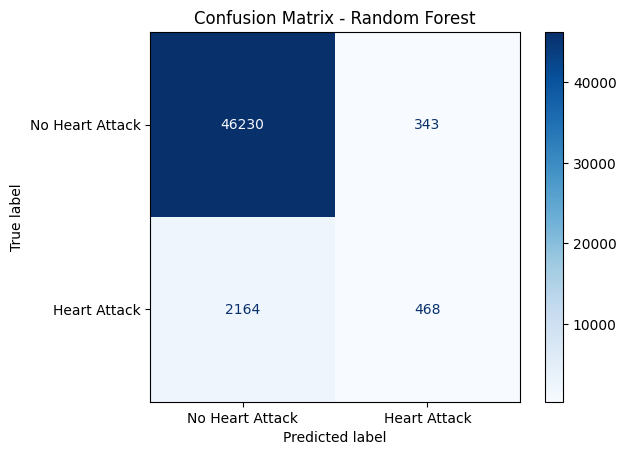


MODEL COMPARISON

Logistic Regression ROC AUC: 0.8877771680723213
Random Forest ROC AUC: 0.8684907316467654


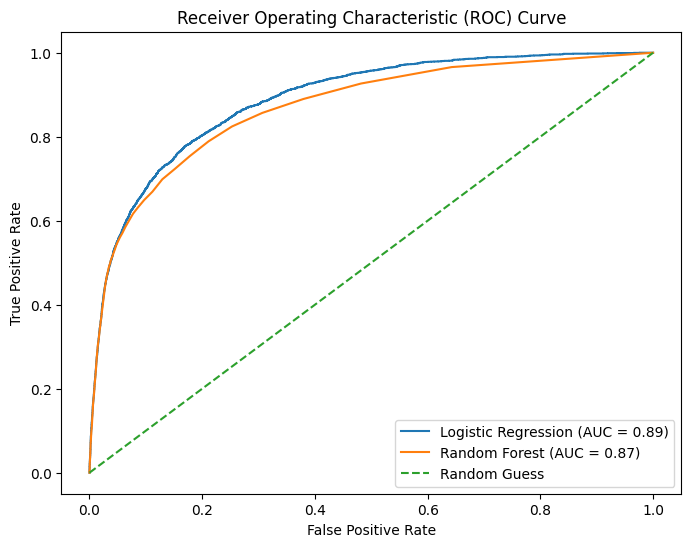

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/moiz/Downloads/heart_2022_no_nans.csv')

# Separate features and target
X = df.drop('HadHeartAttack', axis=1)
y = df['HadHeartAttack']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Heart Attack', 'Heart Attack'])
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

# Logistic Regression
print("\n" + "="*50)
print("LOGISTIC REGRESSION MODEL FOR HEART ATTACK PREDICTION")
print("="*50 + "\n")

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

lr_predictions = lr_model.predict(X_test_scaled)
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("\nLogistic Regression Results:")
print(classification_report(y_test, lr_predictions))
print(f"ROC AUC Score: {roc_auc_score(y_test, lr_proba):.4f}")

plot_confusion_matrix(y_test, lr_predictions, "Confusion Matrix - Logistic Regression")

# Random Forest
print("\n" + "="*50)
print("RANDOM FOREST MODEL FOR HEART ATTACK PREDICTION")
print("="*50 + "\n")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

rf_predictions = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\nRandom Forest Results:")
print(classification_report(y_test, rf_predictions))
print(f"ROC AUC Score: {roc_auc_score(y_test, rf_proba):.4f}")

plot_confusion_matrix(y_test, rf_predictions, "Confusion Matrix - Random Forest")

# Compare models
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50 + "\n")

print("Logistic Regression ROC AUC:", roc_auc_score(y_test, lr_proba))
print("Random Forest ROC AUC:", roc_auc_score(y_test, rf_proba))

# Plot ROC curves
plt.figure(figsize=(8, 6))
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, lr_proba):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_proba):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()